In [ ]:
import tensorflow as tf
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

dataset_path = '/content/drive/MyDrive/dataset/train'

# Create datasets with a 20-80 train-validation split
train_dataset = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(224, 224),
    batch_size=32
)

val_dataset = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(224, 224),
    batch_size=32
)

# Normalize the pixel values
def preprocess(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

# Define data augmentation pipeline
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(0.2),           # Random rotations up to 20%
    tf.keras.layers.RandomWidth(0.2),              # Random horizontal shifts
    tf.keras.layers.RandomHeight(0.2),             # Random vertical shifts
    tf.keras.layers.RandomZoom(0.2),               # Random zooms
    tf.keras.layers.RandomFlip("horizontal"),      # Random horizontal flips
])

# Preprocess training data with augmentation
def preprocess_with_augmentation(image, label):
    image = tf.cast(image, tf.float32) / 255.0  # Normalize pixel values
    image = data_augmentation(image)  # Apply augmentation
    return image, label

# Apply preprocessing and augmentation to the training data
train_dataset = train_dataset.map(preprocess_with_augmentation)

# Apply preprocessing (without augmentation) to the validation data
val_dataset = val_dataset.map(preprocess)

# Optimize for performance
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)

# Print confirmation
print("Data augmentation applied to the training dataset!")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 633 files belonging to 4 classes.
Using 507 files for training.
Found 633 files belonging to 4 classes.
Using 126 files for validation.
Data augmentation applied to the training dataset!


In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import (VGG19,DenseNet201, MobileNetV2,InceptionResNetV2)

def build_and_train_model(base_model, train_dataset, val_dataset, num_classes=4, model_name=""):
    # Freeze the base model
    base_model.trainable = False

    # Build the model
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    # Train the model
    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=50,
        callbacks=[
            tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        ]
    )

    # Evaluate
    val_loss, val_accuracy = model.evaluate(val_dataset)
    print(f"{model_name} - Validation Accuracy: {val_accuracy:.2f}")

    return model, history


In [ ]:
# Import necessary libraries
from tensorflow.keras.applications import (VGG19, InceptionResNetV2, DenseNet201,MobileNetV2)

# Define models to train
pretrained_models = [
    ("VGG19", VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3)))
]

# Storage for trained models and results
trained_models = {}
model_histories = {}
results = []

# Train each model
for model_name, base_model in pretrained_models:
    print(f"Training {model_name}...")
    model, history = build_and_train_model(base_model, train_dataset, val_dataset, model_name=model_name)
    trained_models[model_name] = model
    model_histories[model_name] = history
    val_loss, val_accuracy = model.evaluate(val_dataset)
    results.append((model_name, val_accuracy))


Training VGG19...
Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 219s 13s/step - accuracy: 0.2890 - loss: 1.5422 - val_accuracy: 0.2540 - val_loss: 1.3518
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 50s 191ms/step - accuracy: 0.3337 - loss: 1.3738 - val_accuracy: 0.4683 - val_loss: 1.2863
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 197ms/step - accuracy: 0.3544 - loss: 1.3142 - val_accuracy: 0.5159 - val_loss: 1.2363
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 193ms/step - accuracy: 0.4657 - loss: 1.2403 - val_accuracy: 0.5476 - val_loss: 1.2170
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 194ms/step - accuracy: 0.4066 - loss: 1.2494 - val_accuracy: 0.5159 - val_loss: 1.2031
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 197ms/step - accuracy: 0.5363 - loss: 1.1355 - val_accuracy: 0.5397 - val_loss: 1.1703
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 199ms/step - accuracy: 0.4506 - loss: 1.1868 - val_accuracy: 0.4206 - val_loss: 1.2036
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 201ms/step - accuracy: 0.5078 - loss: 1.1626

In [ ]:
# Fine-tune each model
fine_tuned_results = []

for model_name, base_model in pretrained_models:
    print(f"Fine-tuning {model_name}...")
    trained_model = trained_models[model_name]
    base_model.trainable = True  # Unfreeze base model

    # Compile with lower learning rate
    trained_model.compile(
        optimizer=Adam(learning_rate=1e-5),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    # Fine-tune the model
    fine_tune_history = trained_model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=20,
        callbacks=[
            tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7),
            tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        ]
    )

    # Evaluate fine-tuned model
    val_loss, val_accuracy = trained_model.evaluate(val_dataset)
    fine_tuned_results.append((model_name, val_accuracy))
    print(f"{model_name} - Fine-tuned Validation Accuracy: {val_accuracy:.2f}")


Fine-tuning VGG19...
Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 622s 38s/step - accuracy: 0.6214 - loss: 0.9304 - val_accuracy: 0.5873 - val_loss: 1.0187 - learning_rate: 1.0000e-05
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 611ms/step - accuracy: 0.7143 - loss: 0.7470 - val_accuracy: 0.5952 - val_loss: 0.9852 - learning_rate: 1.0000e-05
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 615ms/step - accuracy: 0.7796 - loss: 0.5650 - val_accuracy: 0.5635 - val_loss: 1.0437 - learning_rate: 1.0000e-05
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 634ms/step - accuracy: 0.8353 - loss: 0.4600 - val_accuracy: 0.5794 - val_loss: 1.1304 - learning_rate: 1.0000e-05
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 618ms/step - accuracy: 0.8764 - loss: 0.3889 - val_accuracy: 0.5714 - val_loss: 1.0928 - learning_rate: 1.0000e-05
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 617ms/step - accuracy: 0.9231 - loss: 0.2739 - val_accuracy: 0.5873 - val_loss: 1.0789 - learning_rate: 2.0000e-06
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
import numpy as np

# Gather predictions from fine-tuned models
predictions = []
for model_name in trained_models:
    print(f"Predicting with {model_name}...")
    model = trained_models[model_name]
    preds = model.predict(val_dataset)
    predictions.append(preds)

# Average predictions across models
ensemble_preds = np.mean(predictions, axis=0)

# Convert ensemble predictions to class labels
final_preds = np.argmax(ensemble_preds, axis=1)

# Evaluate ensemble performance
from sklearn.metrics import accuracy_score

y_true = np.concatenate([y for x, y in val_dataset], axis=0)  # True labels
ensemble_accuracy = accuracy_score(y_true, final_preds)
print(f"Ensemble Model Accuracy: {ensemble_accuracy:.2f}")


Predicting with VGG19...
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 272ms/step
Ensemble Model Accuracy: 0.60


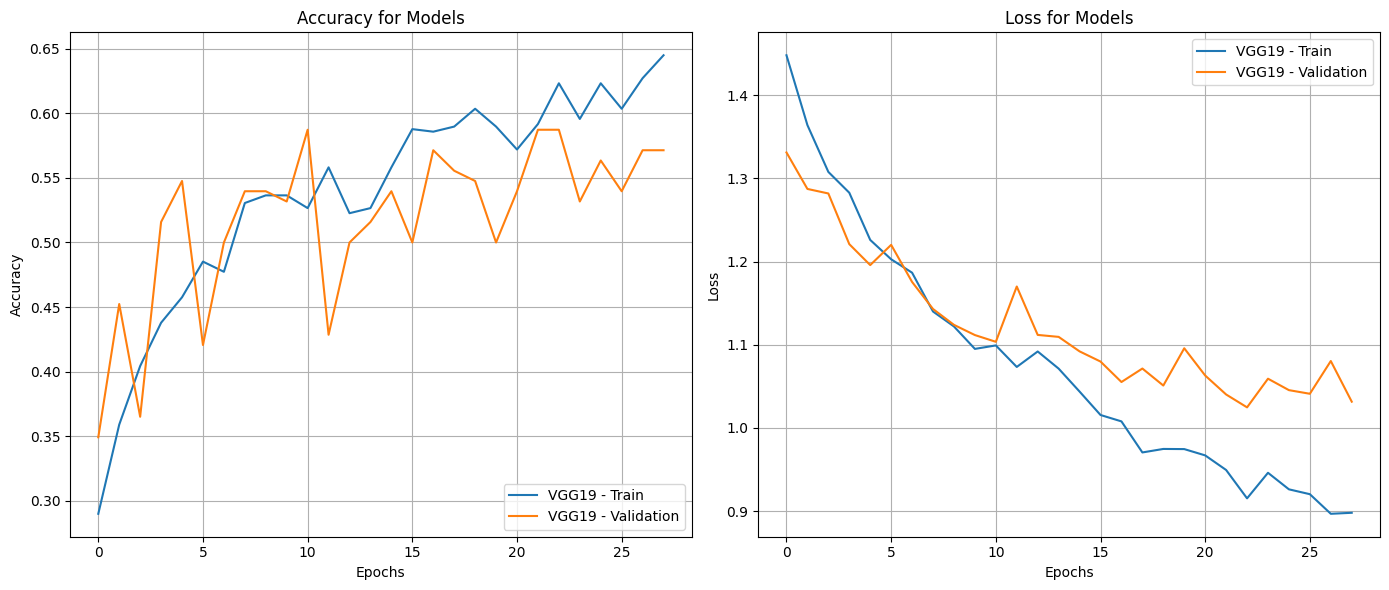

Evaluating VGG19...
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


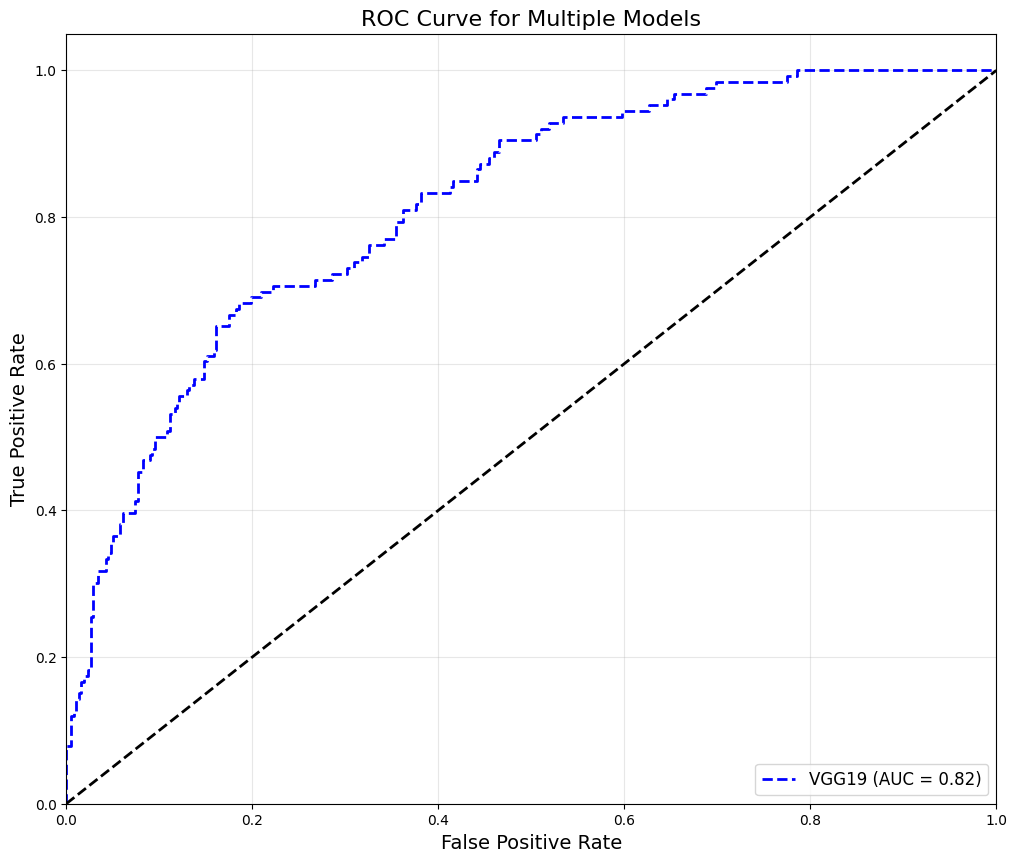

In [ ]:
# Plot Loss/Accuracy
plot_loss_accuracy_graphs(model_histories, [model_name for model_name, _ in models_to_train])

# Plot ROC Curve
plot_roc_curve(trained_models, val_dataset, n_classes=4)


Evaluating VGG19...
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 259ms/step


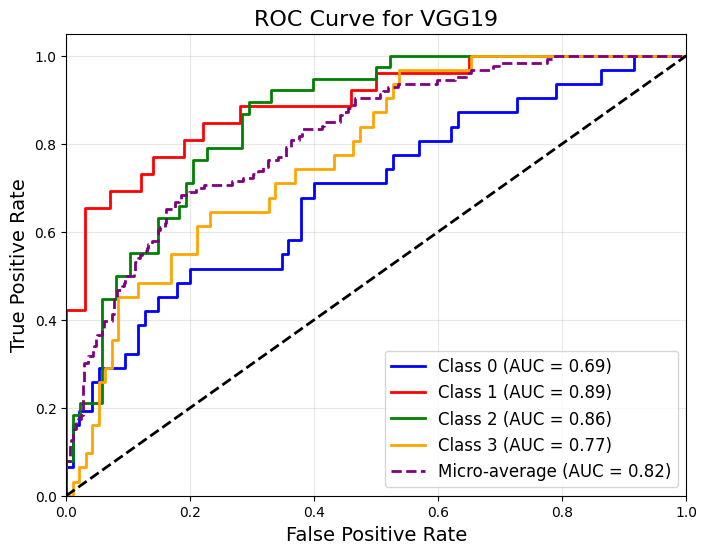

In [ ]:
def plot_roc_curve_separate(models, val_dataset, n_classes=4):
    """
    Plot separate ROC curves for each model.
    """
    for model_name, model in models:
        print(f"Evaluating {model_name}...")

        # Get true labels and predictions
        y_true = np.concatenate([y for _, y in val_dataset], axis=0)
        y_pred_proba = model.predict(val_dataset)

        # One-hot encode true labels
        y_true_bin = label_binarize(y_true, classes=range(n_classes))

        # Compute ROC curve and AUC
        fpr, tpr, roc_auc = {}, {}, {}
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        # Micro-average ROC curve
        fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_pred_proba.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

        # Plot ROC curve for the current model
        plt.figure(figsize=(8, 6))
        colors = cycle(["blue", "red", "green", "orange"])

        for i, color in zip(range(n_classes), colors):
            plt.plot(
                fpr[i], tpr[i], color=color, lw=2,
                label=f"Class {i} (AUC = {roc_auc[i]:.2f})"
            )

        # Plot micro-average
        plt.plot(
            fpr["micro"], tpr["micro"], color="purple", linestyle="--", lw=2,
            label=f"Micro-average (AUC = {roc_auc['micro']:.2f})"
        )

        plt.plot([0, 1], [0, 1], "k--", lw=2)  # Diagonal line
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel("False Positive Rate", fontsize=14)
        plt.ylabel("True Positive Rate", fontsize=14)
        plt.title(f"ROC Curve for {model_name}", fontsize=16)
        plt.legend(loc="lower right", fontsize=12)
        plt.grid(alpha=0.3)
        plt.show()

# Plot ROC curve for each model separately
plot_roc_curve_separate(trained_models, val_dataset, n_classes=4)
